In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
import sklearn as sk
import warnings
warnings.filterwarnings("ignore")

In [3]:
nifty_50 = pd.read_csv(r"D:\Macro Research\Data\Processed Data\Equity Benchmark\NIFTY50.csv", parse_dates=["Date"])
nifty_50.set_index("Date", inplace=True)
nifty_50_min_date = nifty_50.index.min()
nifty_50_max_date = nifty_50.index.max()

print(f"nifty_50_min_date: {nifty_50_min_date}")
print(f"nifty_50_max_date: {nifty_50_max_date}")
nifty_50.isna().sum()
nifty_midcap = pd.read_csv(r"D:\Macro Research\Data\Processed Data\Equity Benchmark\NIFTYMid.csv", parse_dates=["Date"])
nifty_midcap.set_index("Date", inplace=True)
nifty_midcap_min_date = nifty_midcap.first_valid_index()
nifty_midcap_max_date = nifty_midcap.last_valid_index()
print(f"nifty_midcap_min_date: {nifty_midcap_min_date}")
print(f"nifty_midcap_max_date: {nifty_midcap_max_date}")
nifty_midcap.isna().sum()
nifty_smallcap = pd.read_csv(r"D:\Macro Research\Data\Processed Data\Equity Benchmark\NIFTYSmall.csv",
                             parse_dates=["Date"])
nifty_smallcap.set_index("Date", inplace=True)
nifty_smallcap_min_date = nifty_smallcap.first_valid_index()
nifty_smallcap_max_date = nifty_smallcap.last_valid_index()

print(f"nifty_smallcap_min_date: {nifty_smallcap_min_date}")
print(f"nigty_smallcap_max_date: {nifty_smallcap_max_date}")
nifty_smallcap.isna().sum()
start_date = nifty_midcap_min_date
end_date = nifty_midcap_max_date
nifty_50[nifty_50.index >= start_date]
nifty_indices = pd.concat([nifty_50, nifty_midcap, nifty_smallcap], axis=1)
nifty_indices = nifty_indices[nifty_indices.index >= start_date]
nifty_indices.isna().sum()
nifty_indices = nifty_indices.dropna()
nifty_indices

nifty_50_min_date: 1995-12-29 00:00:00
nifty_50_max_date: 2025-11-14 00:00:00
nifty_midcap_min_date: 2005-07-18 00:00:00
nifty_midcap_max_date: 2025-11-14 00:00:00
nifty_smallcap_min_date: 2004-01-01 00:00:00
nigty_smallcap_max_date: 2025-11-14 00:00:00


.NSEI  .NIFMDCP100  .NIFSMCP100
Date                                          
2005-07-18   2234.00      3364.10      1780.51
2005-07-19   2237.30      3396.35      1790.17
2005-07-20   2241.90      3417.05      1794.31
2005-07-21   2230.50      3401.15      1783.65
2005-07-22   2265.60      3440.10      1799.72
...              ...          ...          ...
2025-11-10  25574.35     60124.25     18138.60
2025-11-11  25694.95     60427.00     18101.40
2025-11-12  25875.80     60902.30     18250.45
2025-11-13  25879.15     60692.05     18183.65
2025-11-14  25910.05     60739.20     18252.50

[5085 rows x 3 columns]

In [4]:
def compute_monthly_full_metrics(df, windows=[3, 6, 12]):
    """
    Compute:
      - true last-trading-day monthly prices
      - monthly log returns
      - rolling returns (3m, 6m, 12m)
      - rolling drawdown (3m, 6m, 12m)
      - rolling semi-standard deviation (3m, 6m, 12m)
      - annualized semi-standard deviation
    """

    # --- PREP ---
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df[~df.index.duplicated(keep="last")]

    tickers = df.columns

    # --- TRUE LAST TRADING-DAY MONTHLY PRICES ---
    last_trade_dates = df.groupby(df.index.to_period("M")).apply(lambda g: g.index[-1])
    monthly_prices = df.loc[last_trade_dates.values]

    # --- MONTHLY LOG RETURN ---
    monthly_logret = np.log(monthly_prices / monthly_prices.shift(1))

    # --- ROLLING RETURNS ---
    rolling_returns = {
        f"Return{w}m": monthly_prices.pct_change(w)
        for w in windows
    }

    # --- ROLLING DRAWDOWN ---
    def rolling_drawdown(prices, w):
        roll_max = prices.rolling(w).max()
        return prices / roll_max - 1

    rolling_dd = {
        f"Drawdown{w}m": rolling_drawdown(monthly_prices, w)
        for w in windows
    }

    # --- SEMI-STANDARD DEV ---
    def semi_std(x):
        neg = np.minimum(x, 0)
        return np.sqrt((neg**2).mean())

    rolling_semistd = {
        f"SemiStd{w}m": monthly_logret.rolling(w).apply(lambda x: semi_std(x.values), raw=False)
        for w in windows
    }

    # rolling_semistd_annual = {
    #     f"SemiStd{w}mAnnual": rolling_semistd[f"SemiStd{w}m"] * np.sqrt(12)
    #     for w in windows
    # }

    # --- COMBINE ---
    combined = {
        "MonthlyPrice": monthly_prices,
        "LogReturn": monthly_logret
    }

    combined.update(rolling_returns)
    combined.update(rolling_dd)
    combined.update(rolling_semistd)
    #combined.update(rolling_semistd_annual)

    out = pd.concat(combined, axis=1)

    # --- FLATTEN COLUMNS INTO SINGLE LEVEL ---
    new_cols = []
    for metric, ticker in out.columns:
        new_col = f"{metric}_{ticker}".replace("__", "_")
        new_cols.append(new_col)

    out.columns = new_cols

    return out

In [5]:
monthly_indices_metrics = compute_monthly_full_metrics(nifty_indices, windows=[3, 6, 12])
monthly_indices_metrics

MonthlyPrice_.NSEI  MonthlyPrice_.NIFMDCP100  \
Date                                                       
2005-07-29             2312.30                   3408.90   
2005-08-31             2384.65                   3663.05   
2005-09-30             2601.40                   3807.40   
2005-10-31             2370.95                   3478.65   
2005-11-30             2652.25                   3832.50   
...                        ...                       ...   
2025-07-31            24768.35                  57400.55   
2025-08-29            24426.85                  55727.40   
2025-09-30            24611.10                  56529.30   
2025-10-31            25722.10                  59825.90   
2025-11-14            25910.05                  60739.20   

            MonthlyPrice_.NIFSMCP100  LogReturn_.NSEI  LogReturn_.NIFMDCP100  \
Date                                                                           
2005-07-29                   1779.25              NaN                    NaN   
2005-08-31                   2043.18         0.030810               0.071906   
2005-09-30                   2074.62         0.086997               0.038650   
2005-10-31                   1852.05        -0.092759              -0.090302   
2005-11-30                   2065.62         0.112118               0.096873   
...                              ...              ...                    ...   
2025-07-31                  17966.85        -0.029780              -0.039968   
2025-08-29                  17227.00        -0.013884              -0.029582   
2025-09-30                  17562.75         0.007515               0.014287   
2025-10-31                  18380.80         0.044153               0.056680   
2025-11-14                  18252.50         0.007280               0.015151   

            LogReturn_.NIFSMCP100  Return3m_.NSEI  Return3m_.NIFMDCP100  \
Date                                                                      
2005-07-29                    NaN             NaN                   NaN   
2005-08-31               0.138315             NaN                   NaN   
2005-09-30               0.015271             NaN                   NaN   
2005-10-31              -0.113485        0.025364              0.020461   
2005-11-30               0.109137        0.112218              0.046259   
...                           ...             ...                   ...   
2025-07-31              -0.059855        0.017841              0.060520   
2025-08-29              -0.042050       -0.013084             -0.029478   
2025-09-30               0.019302       -0.035504             -0.053764   
2025-10-31               0.045526        0.038507              0.042253   
2025-11-14              -0.007005        0.060720              0.089934   

            Return3m_.NIFSMCP100  Return6m_.NSEI  ...  \
Date                                              ...   
2005-07-29                   NaN             NaN  ...   
2005-08-31                   NaN             NaN  ...   
2005-09-30                   NaN             NaN  ...   
2005-10-31              0.040916             NaN  ...   
2005-11-30              0.010983             NaN  ...   
...                          ...             ...  ...   
2025-07-31              0.092286        0.053596  ...   
2025-08-29             -0.036699        0.104053  ...   
2025-09-30             -0.079284        0.046419  ...   
2025-10-31              0.023040        0.057035  ...   
2025-11-14              0.059529        0.046841  ...   

            Drawdown12m_.NIFSMCP100  SemiStd3m_.NSEI  SemiStd3m_.NIFMDCP100  \
Date                                                                          
2005-07-29                      NaN              NaN                    NaN   
2005-08-31                      NaN              NaN                    NaN   
2005-09-30                      NaN              NaN                    NaN   
2005-10-31                      NaN         0.053554               0.052136  

In [6]:
def group_features_by_type(columns):
    """Group columns by feature type"""
    feature_groups = {
        'LogReturn': [],
        'ReturnXm': [],
        'DrawdownXm': [],
        'SemiStdXm': []
    }

    for col in columns:
        if col.startswith('LogReturn_'):
            feature_groups['LogReturn'].append(col)
        elif any(col.startswith(f'Return{period}m_') for period in [3, 6, 12]):
            feature_groups['ReturnXm'].append(col)
        elif any(col.startswith(f'Drawdown{period}m_') for period in [3, 6, 12]):
            feature_groups['DrawdownXm'].append(col)
        elif any(col.startswith(f'SemiStd{period}m_') for period in [3, 6, 12]):
            feature_groups['SemiStdXm'].append(col)

    return feature_groups


feature_groups = group_features_by_type(monthly_indices_metrics.columns)
feature_groups

{'LogReturn': ['LogReturn_.NSEI',
  'LogReturn_.NIFMDCP100',
  'LogReturn_.NIFSMCP100'],
 'ReturnXm': ['Return3m_.NSEI',
  'Return3m_.NIFMDCP100',
  'Return3m_.NIFSMCP100',
  'Return6m_.NSEI',
  'Return6m_.NIFMDCP100',
  'Return6m_.NIFSMCP100',
  'Return12m_.NSEI',
  'Return12m_.NIFMDCP100',
  'Return12m_.NIFSMCP100'],
 'DrawdownXm': ['Drawdown3m_.NSEI',
  'Drawdown3m_.NIFMDCP100',
  'Drawdown3m_.NIFSMCP100',
  'Drawdown6m_.NSEI',
  'Drawdown6m_.NIFMDCP100',
  'Drawdown6m_.NIFSMCP100',
  'Drawdown12m_.NSEI',
  'Drawdown12m_.NIFMDCP100',
  'Drawdown12m_.NIFSMCP100'],
 'SemiStdXm': ['SemiStd3m_.NSEI',
  'SemiStd3m_.NIFMDCP100',
  'SemiStd3m_.NIFSMCP100',
  'SemiStd6m_.NSEI',
  'SemiStd6m_.NIFMDCP100',
  'SemiStd6m_.NIFSMCP100',
  'SemiStd12m_.NSEI',
  'SemiStd12m_.NIFMDCP100',
  'SemiStd12m_.NIFSMCP100']}

In [7]:
y_feature_df = monthly_indices_metrics[feature_groups['LogReturn'] + feature_groups['ReturnXm'] + feature_groups['DrawdownXm'] + feature_groups['SemiStdXm']]
y_feature_df

LogReturn_.NSEI  LogReturn_.NIFMDCP100  LogReturn_.NIFSMCP100  \
Date                                                                        
2005-07-29              NaN                    NaN                    NaN   
2005-08-31         0.030810               0.071906               0.138315   
2005-09-30         0.086997               0.038650               0.015271   
2005-10-31        -0.092759              -0.090302              -0.113485   
2005-11-30         0.112118               0.096873               0.109137   
...                     ...                    ...                    ...   
2025-07-31        -0.029780              -0.039968              -0.059855   
2025-08-29        -0.013884              -0.029582              -0.042050   
2025-09-30         0.007515               0.014287               0.019302   
2025-10-31         0.044153               0.056680               0.045526   
2025-11-14         0.007280               0.015151              -0.007005   

            Return3m_.NSEI  Return3m_.NIFMDCP100  Return3m_.NIFSMCP100  \
Date                                                                     
2005-07-29             NaN                   NaN                   NaN   
2005-08-31             NaN                   NaN                   NaN   
2005-09-30             NaN                   NaN                   NaN   
2005-10-31        0.025364              0.020461              0.040916   
2005-11-30        0.112218              0.046259              0.010983   
...                    ...                   ...                   ...   
2025-07-31        0.017841              0.060520              0.092286   
2025-08-29       -0.013084             -0.029478             -0.036699   
2025-09-30       -0.035504             -0.053764             -0.079284   
2025-10-31        0.038507              0.042253              0.023040   
2025-11-14        0.060720              0.089934              0.059529   

            Return6m_.NSEI  Return6m_.NIFMDCP100  Return6m_.NIFSMCP100  \
Date                                                                     
2005-07-29             NaN                   NaN                   NaN   
2005-08-31             NaN                   NaN                   NaN   
2005-09-30             NaN                   NaN                   NaN   
2005-10-31             NaN                   NaN                   NaN   
2005-11-30             NaN                   NaN                   NaN   
...                    ...                   ...                   ...   
2025-07-31        0.053596              0.068669              0.062467   
2025-08-29        0.104053              0.163042              0.171889   
2025-09-30        0.046419              0.093997              0.091145   
2025-10-31        0.057035              0.105330              0.117452   
2025-11-14        0.046841              0.057806              0.020645   

            Return12m_.NSEI  ...  Drawdown12m_.NIFSMCP100  SemiStd3m_.NSEI  \
Date                         ...                                             
2005-07-29              NaN  ...                      NaN              NaN   
2005-08-31              NaN  ...                      NaN              NaN   
2005-09-30              NaN  ...                      NaN              NaN   
2005-10-31              NaN  ...                      NaN         0.053554   
2005-11-30              NaN  ...                      NaN         0.053554   
...                     ...  ...                      ...              ...   
2025-07-31        -0.007326  ...                -0.069417         0.017194   
2025-08-29        -0.032059  ...                -0.101808         0.018970   
2025-09-30        -0.046482  ...                -0.079284         0.018970   
2025-10-31         0.062662  ...                -0.036398         0.008016   
2025-11-14         0.073720  ...                -0.043124         0.000000   

            SemiStd3m_.NIFMDCP100  SemiStd3m_.NIFSMCP100  SemiStd6m_.

In [8]:
# Compact version focusing on mean, median, skew, kurtosis
def create_compact_summary(df):
    """Create a compact summary with mean, median, skew, and kurtosis"""

    results = []

    for column in df.columns:
        data = df[column].dropna()

        if len(data) > 0:
            stats = {
                'Column': column,
                'Mean': f"{data.mean():.4f}",
                'Median': f"{data.median():.4f}",
                'Skewness': f"{skew(data, nan_policy='omit'):.4f}",
                'Kurtosis': f"{kurtosis(data, nan_policy='omit', fisher=True):.4f}",
                'N': len(data),
                'Min': f"{data.min():.4f}",
                'Max': f"{data.max():.4f}"
            }
            results.append(stats)

    summary_df = pd.DataFrame(results)
    return summary_df

# Create and display compact summary
compact_summary = create_compact_summary(y_feature_df)

# Display with better formatting
print("\n" + "=" * 120)
print("COMPACT SUMMARY STATISTICS")
print("=" * 120)
print(compact_summary.to_string(index=False))

# Or display by variable type
print("\n" + "=" * 120)
print("BY VARIABLE TYPE")
print("=" * 120)

# Categorize columns
log_return_cols = [c for c in y_feature_df.columns if 'LogReturn' in c]
return_cols = [c for c in y_feature_df.columns if any(x in c for x in ['Return3m', 'Return6m', 'Return12m'])]
drawdown_cols = [c for c in y_feature_df.columns if 'Drawdown' in c]
semistd_cols = [c for c in y_feature_df.columns if 'SemiStd' in c]

categories = [
    ("Log Returns", log_return_cols),
    ("Returns (3m, 6m, 12m)", return_cols),
    ("Drawdowns", drawdown_cols),
    ("Semi-Standard Deviations", semistd_cols)
]

for category_name, cols in categories:
    if cols:
        print(f"\n{category_name}:")
        print("-" * 80)
        cat_summary = compact_summary[compact_summary['Column'].isin(cols)]
        print(cat_summary.to_string(index=False))


COMPACT SUMMARY STATISTICS
                 Column    Mean  Median Skewness Kurtosis   N     Min    Max
        LogReturn_.NSEI  0.0099  0.0108  -0.9160   5.1050 244 -0.3067 0.2474
  LogReturn_.NIFMDCP100  0.0118  0.0197  -1.0164   5.2421 244 -0.3607 0.3269
  LogReturn_.NIFSMCP100  0.0095  0.0188  -1.2429   6.8068 244 -0.4687 0.3875
         Return3m_.NSEI  0.0351  0.0358   0.4105   4.8163 242 -0.3681 0.6098
   Return3m_.NIFMDCP100  0.0443  0.0436   0.4216   3.1397 242 -0.4193 0.6858
   Return3m_.NIFSMCP100  0.0417  0.0401   0.4491   3.6904 242 -0.5625 0.8727
         Return6m_.NSEI  0.0715  0.0634   0.4801   2.8861 239 -0.4414 0.6869
   Return6m_.NIFMDCP100  0.0923  0.0759   0.5709   2.1354 239 -0.4994 0.9702
   Return6m_.NIFSMCP100  0.0883  0.0751   0.5049   1.6424 239 -0.6219 1.1121
        Return12m_.NSEI  0.1398  0.1167   0.2088   1.4027 233 -0.5219 0.8267
  Return12m_.NIFMDCP100  0.1898  0.1180   0.6596   0.9481 233 -0.5939 1.2612
  Return12m_.NIFSMCP100  0.1795  0.0900   0.6512

In [9]:
eikon_df = pd.read_csv("D:\Macro Research\Data\Processed Data\Economics Data\eikon_cpi_fdi_wpi.csv",
                       parse_dates=["Date"])
eikon_df.set_index("Date", inplace=True)
cpi_df = eikon_df['CPI, Inflation rate']
fdi_df = eikon_df['FDI']
wpi = eikon_df['India, WPI Inflation- Actual, Chg Y/Y']
ind_repo_rate_df = pd.read_csv("D:\Macro Research\Data\Processed Data\Economics Data\indian_repo.csv",
                               parse_dates=["Date"])
ind_repo_rate_df.set_index("Date", inplace=True)
repo_monthly = ind_repo_rate_df.resample("M").ffill()
repo_monthly = repo_monthly.rename(columns={"INRPYLDP Index": "RepoRate"})
repo_monthly = repo_monthly['RepoRate']

# --- Prepare macro data ---
macro = pd.DataFrame({
    "CPI": cpi_df,
    "WPI": wpi,
    "FDI": fdi_df,
    "REPO": repo_monthly
})

macro.index = pd.to_datetime(macro.index)
macro.index = macro.index.to_period("M")

macro['FDI change'] = macro['FDI'].pct_change()
macro['REPO change'] = macro['REPO'].pct_change()
macro

CPI   WPI           FDI  REPO  FDI change  REPO change
Date                                                                
2000-01  2.619048   NaN  1.190000e+08   NaN         NaN          NaN
2000-02  3.614458   NaN  2.900000e+08   NaN    1.436975          NaN
2000-03  4.830918   NaN  2.570000e+08   NaN   -0.113793          NaN
2000-04  5.542169   NaN  8.300000e+07   NaN   -0.677043          NaN
2000-05  5.011933   NaN  3.490000e+08   NaN    3.204819          NaN
...           ...   ...           ...   ...         ...          ...
2025-06  2.545969 -0.13  2.507000e+09   5.5 -502.400000    -0.083333
2025-07  2.662929 -0.58  5.039000e+09   5.5    1.009972     0.000000
2025-08  3.155680  0.52 -6.160000e+08   5.5   -1.122246     0.000000
2025-09  2.791347  0.13           NaN   5.5    0.000000     0.000000
2025-10       NaN -1.21           NaN   5.5    0.000000     0.000000

[310 rows x 6 columns]

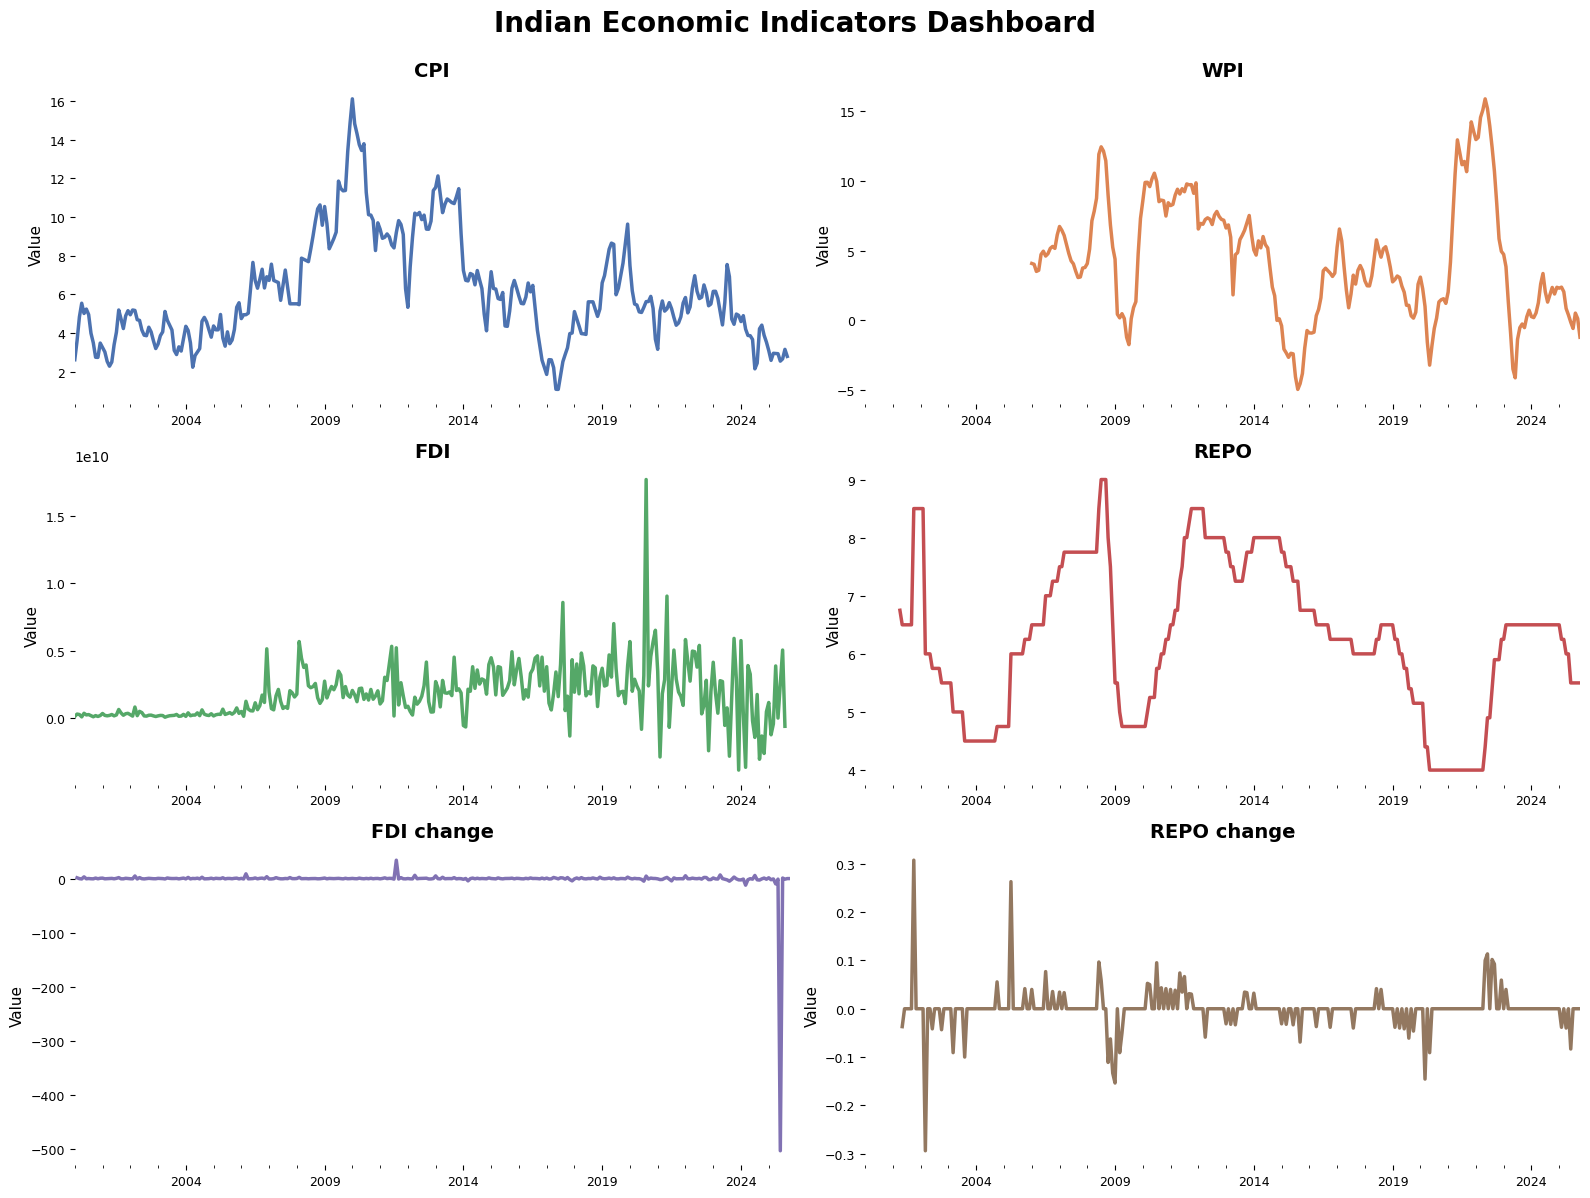

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12), dpi=100)
axes = axes.flatten()

for idx, col in enumerate(macro.columns):
    ax = axes[idx]
    macro[col].plot(ax=ax, linewidth=2.5, color=sns.color_palette("deep")[idx])
    ax.set_title(col, fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Value', fontsize=11)
    ax.tick_params(axis='both', labelsize=9)
    #ax.grid()

    # Remove top and right spines
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.suptitle('Indian Economic Indicators Dashboard',
             fontsize=20, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [11]:
# Create and display compact summary
compact_summary_macro = create_compact_summary(macro)

# Display with better formatting
print("\n" + "=" * 120)
print("COMPACT SUMMARY STATISTICS")
print("=" * 120)
print(compact_summary_macro.to_string(index=False))


COMPACT SUMMARY STATISTICS
     Column            Mean          Median Skewness Kurtosis   N              Min              Max
        CPI          6.0937          5.5118   0.9566   0.6815 309           1.0830          16.1142
        WPI          4.4259          4.0350   0.3486  -0.2644 238          -4.9500          15.8800
        FDI 1781237012.9870 1623500000.0000   1.7840  11.1939 308 -3864000000.0000 17689000000.0000
       REPO          6.2607          6.2500  -0.0524  -0.8488 295           4.0000           9.0000
 FDI change         -1.4581         -0.0606 -17.2775 299.1296 309        -502.4000          33.9396
REPO change          0.0002          0.0000   0.6359  22.2921 294          -0.2941           0.3077


In [12]:
def safe_pct_change(s):
    s = s.replace(0, np.nan)
    out = s.pct_change()
    out = out.replace([np.inf, -np.inf], np.nan)
    return out

In [13]:
ind_10_df = pd.read_csv(
    "D:\Macro Research\Data\Processed Data\Fixed Income Data\India 10-Year Bond Yield Historical Data.csv",
    parse_dates=["Date"], date_format="%d-%m-%Y")
ind_10_df.set_index("Date", inplace=True)
ind_10_df = ind_10_df.sort_index()
ind_10_df = ind_10_df['Price']
ind_2_df = pd.read_csv(
    "D:\Macro Research\Data\Processed Data\Fixed Income Data\India 2-Year Bond Yield Historical Data.csv",
    parse_dates=["Date"], date_format="%d-%m-%Y")
ind_2_df.set_index("Date", inplace=True)
ind_2_df = ind_2_df.sort_index()
ind_2_df = ind_2_df['Price']
ind_10_2_spread = ind_10_df - ind_2_df
us_10_df = pd.read_csv(r"D:\Macro Research\Data\Processed Data\Fixed Income Data\US_10_yield.csv",
                       parse_dates=["observation_date"])
us_10_df.set_index("observation_date", inplace=True)
us_10_df = us_10_df['DGS10'].ffill()
us_2_df = pd.read_csv(r"D:\Macro Research\Data\Processed Data\Fixed Income Data\US_2_yield.csv",
                      parse_dates=["observation_date"])
us_2_df.set_index("observation_date", inplace=True)
us_2_df = us_2_df['DGS2'].ffill()
us_10_2_spread = (us_10_df[us_10_df.index >= "2000-01-01"]) - (us_2_df[us_2_df.index >= "2000-01-01"])
first_trade_dates = us_10_2_spread.groupby(us_10_2_spread.index.to_period("M")).apply(lambda g: g.index[0])
monthly_us_spread = us_10_2_spread.loc[first_trade_dates.values]

# ---- IND SPREAD ----
ind_10_2_spread.index = pd.to_datetime(ind_10_2_spread.index)

# Convert → PeriodIndex(M)
ind_10_2_spread.index = ind_10_2_spread.index.to_period("M")

monthly_us_spread.index = monthly_us_spread.index.to_period("M")

# ---- COMBINE ALL ----
fixed_income = pd.DataFrame({
    "Ind_spread": ind_10_2_spread,
    "Us_spread": monthly_us_spread
})

fixed_income["Us_spread Chg"] = safe_pct_change(fixed_income["Us_spread"])
fixed_income["Ind_spread Chg"] = safe_pct_change(fixed_income["Ind_spread"])
fixed_income

Ind_spread  Us_spread  Us_spread Chg  Ind_spread Chg
2000-01         NaN       0.20            NaN             NaN
2000-02         NaN       0.02      -0.900000             NaN
2000-03         NaN      -0.13      -7.500000             NaN
2000-04         NaN      -0.45       2.461538             NaN
2000-05         NaN      -0.44      -0.022222             NaN
...             ...        ...            ...             ...
2025-07       0.660       0.48      -0.076923        0.180680
2025-08       0.755       0.54       0.125000        0.143939
2025-09       0.849       0.64       0.185185        0.124503
2025-10       0.795       0.57      -0.109375       -0.063604
2025-11       0.723       0.53      -0.070175       -0.090566

[311 rows x 4 columns]

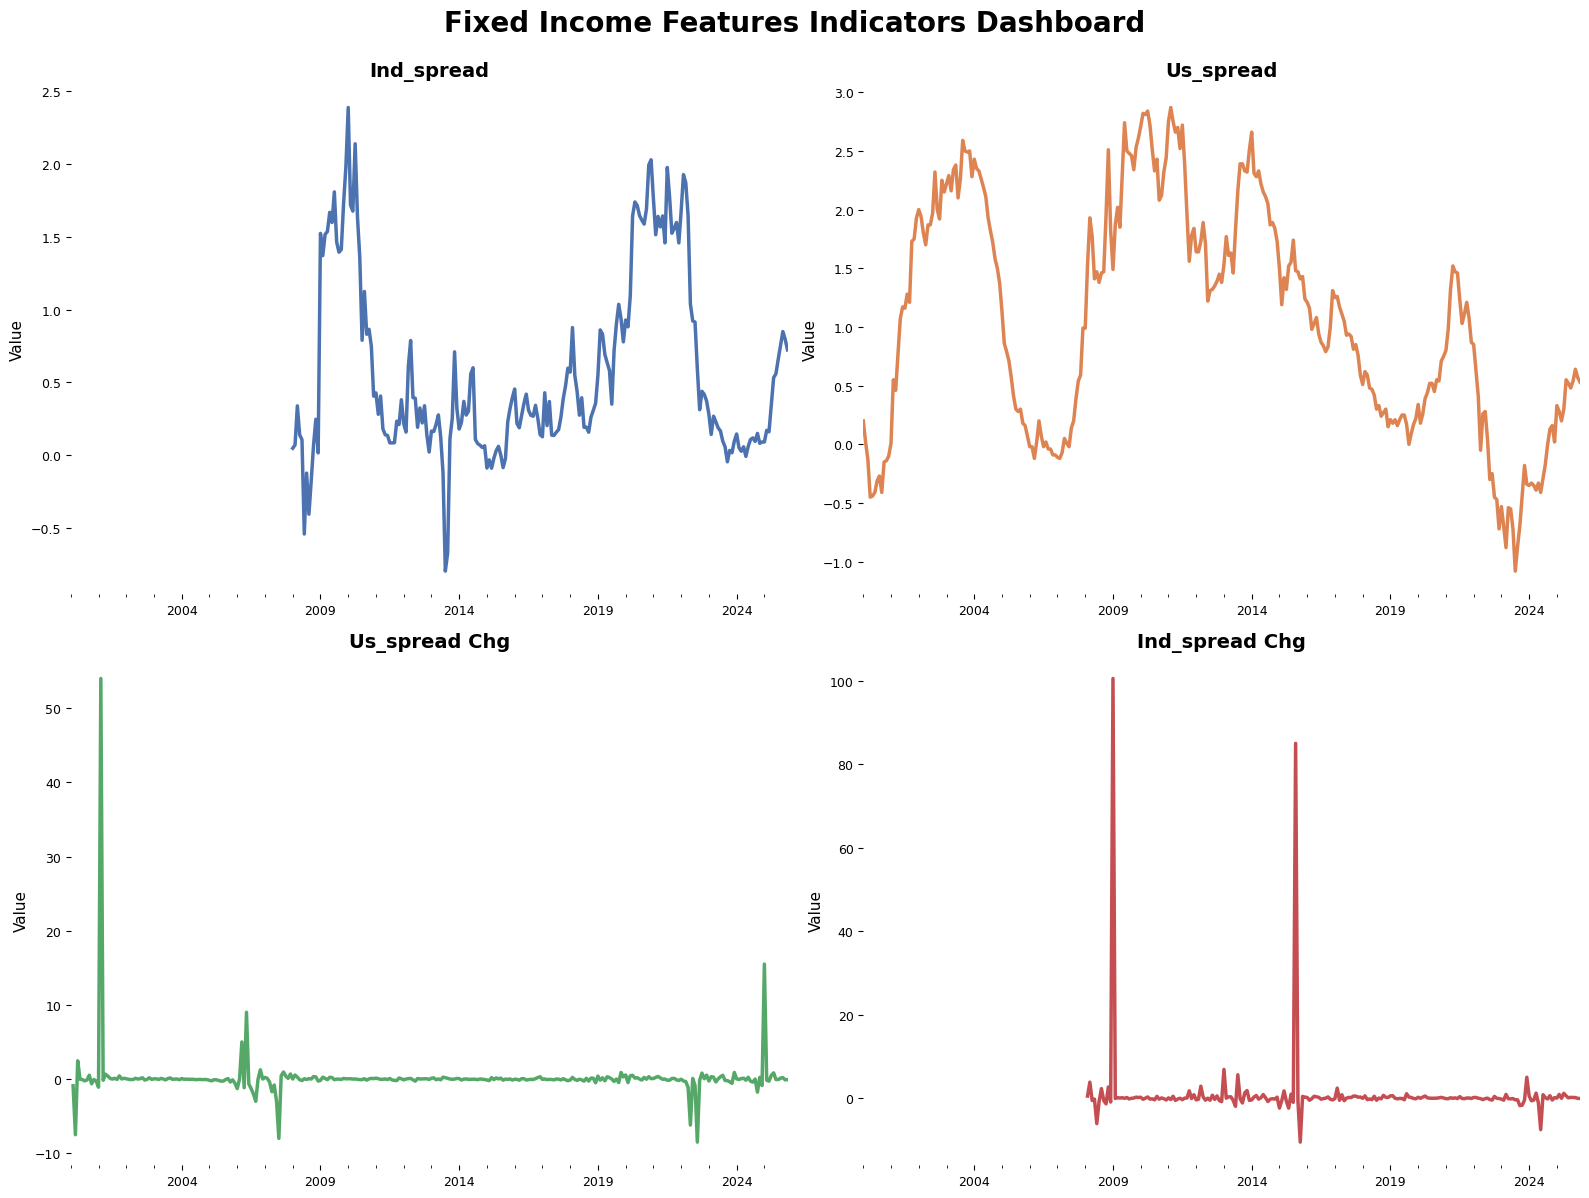

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=100)
axes = axes.flatten()

for idx, col in enumerate(fixed_income.columns):
    ax = axes[idx]
    fixed_income[col].plot(ax=ax, linewidth=2.5, color=sns.color_palette("deep")[idx])
    ax.set_title(col, fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Value', fontsize=11)
    ax.tick_params(axis='both', labelsize=9)
    #ax.grid()

    # Remove top and right spines
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.suptitle('Fixed Income Features Indicators Dashboard',
             fontsize=20, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [15]:
# Create and display compact summary
compact_summary_fixed_income = create_compact_summary(fixed_income)

# Display with better formatting
print("\n" + "=" * 120)
print("COMPACT SUMMARY STATISTICS")
print("=" * 120)
print(compact_summary_fixed_income.to_string(index=False))


COMPACT SUMMARY STATISTICS
        Column   Mean  Median Skewness Kurtosis   N      Min      Max
    Ind_spread 0.5761  0.3380   0.9015  -0.1580 215  -0.7970   2.3880
     Us_spread 1.0609  1.0700   0.0288  -1.1260 311  -1.0800   2.8700
 Us_spread Chg 0.1292 -0.0156  13.2247 206.1779 310  -8.5000  54.0000
Ind_spread Chg 0.8550 -0.0265   9.9293  99.9395 214 -10.5417 100.5333


In [16]:
gold_df = pd.read_csv("D:\Macro Research\Data\Processed Data\Commodity Data\GOLD.csv", parse_dates=["Date"])
gold_df.set_index("Date", inplace=True)
gold_df = gold_df['XAU BGN Curncy']
gold_df = gold_df[gold_df.index >= "2005-01-01"]
first_trade_dates = gold_df.groupby(gold_df.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_gold_df = gold_df.loc[first_trade_dates.values]

silver_df = pd.read_csv("D:\Macro Research\Data\Processed Data\Commodity Data\SILVER.csv", parse_dates=["Date"])
silver_df.set_index("Date", inplace=True)
silver_df = silver_df['XAG BGN Curncy']
silver_df = silver_df[silver_df.index >= "2005-01-01"]
first_trade_dates = silver_df.groupby(silver_df.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_silver_df = silver_df.loc[first_trade_dates.values]
crude_df = pd.read_csv("D:\Macro Research\Data\Processed Data\Commodity Data\CRUDE.csv", parse_dates=["Date"])
crude_df.set_index("Date", inplace=True)
crude_df = crude_df["CO1 Comdty"]
crude_df = crude_df[crude_df.index >= "2005-01-01"]
first_trade_dates = crude_df.groupby(crude_df.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_crude_df = crude_df.loc[first_trade_dates.values]

# Convert → PeriodIndex(M)
monthly_gold_df.index = monthly_gold_df.index.to_period("M")
monthly_silver_df.index = monthly_silver_df.index.to_period("M")
monthly_crude_df.index = monthly_crude_df.index.to_period("M")
# ---- COMBINE ALL ----
commodity = pd.DataFrame({
    "Gold" : monthly_gold_df,
    "Silver" : monthly_silver_df,
    "Crude" : monthly_crude_df
})

commodity = np.log(commodity / commodity.shift(1))

In [17]:
commodity

Gold    Silver     Crude
Date                                 
2005-01       NaN       NaN       NaN
2005-02  0.030413  0.081357  0.086322
2005-03 -0.016899 -0.024984  0.081118
2005-04  0.014025 -0.029959 -0.060751
2005-05 -0.040280  0.069910 -0.007071
...           ...       ...       ...
2025-07 -0.004007  0.016589  0.070244
2025-08  0.046914  0.078685 -0.062729
2025-09  0.112618  0.160758 -0.016280
2025-10  0.036626  0.042876 -0.029527
2025-11  0.040302  0.077684 -0.022693

[251 rows x 3 columns]

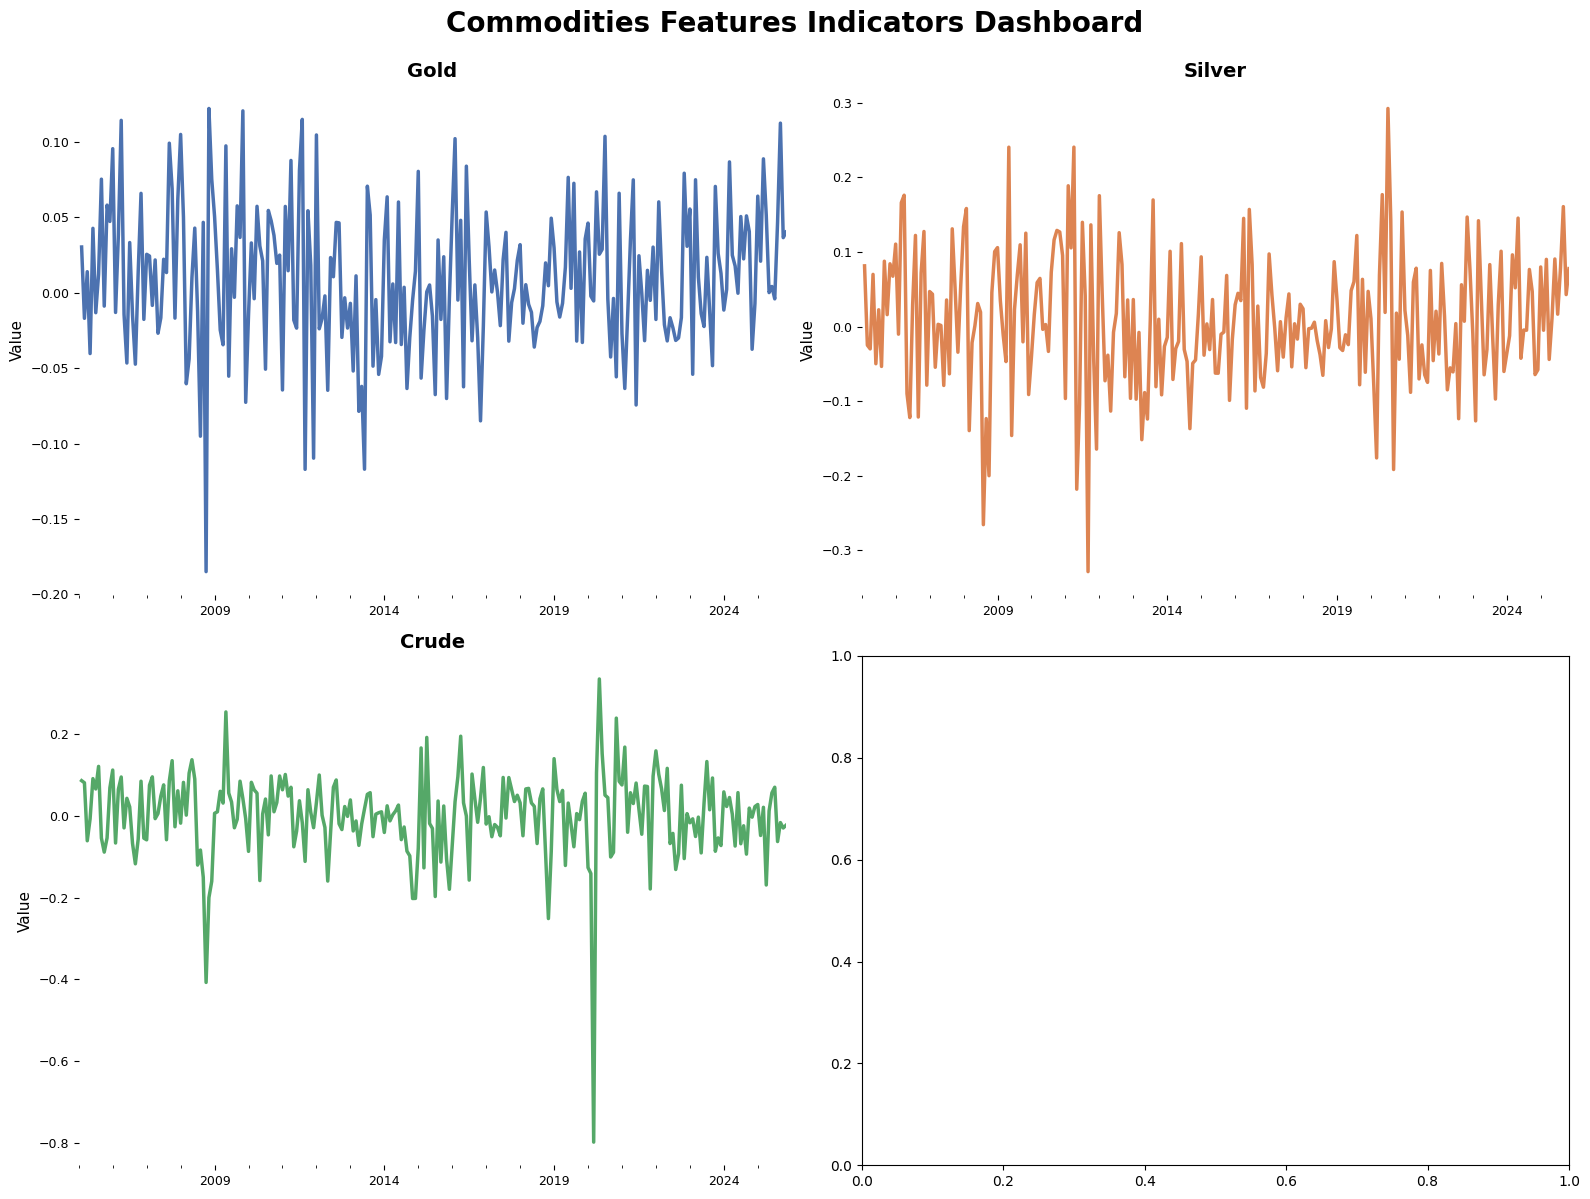

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=100)
axes = axes.flatten()

for idx, col in enumerate(commodity.columns):
    ax = axes[idx]
    commodity[col].plot(ax=ax, linewidth=2.5, color=sns.color_palette("deep")[idx])
    ax.set_title(col, fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Value', fontsize=11)
    ax.tick_params(axis='both', labelsize=9)
    #ax.grid()

    # Remove top and right spines
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.suptitle('Commodities Features Indicators Dashboard',
             fontsize=20, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [19]:
# Create and display compact summary
compact_summary_commodity = create_compact_summary(commodity)

# Display with better formatting
print("\n" + "=" * 120)
print("COMPACT SUMMARY STATISTICS")
print("=" * 120)
print(compact_summary_commodity.to_string(index=False))


COMPACT SUMMARY STATISTICS
Column   Mean Median Skewness Kurtosis   N     Min    Max
  Gold 0.0092 0.0053  -0.1738   0.6201 250 -0.1850 0.1223
Silver 0.0082 0.0038  -0.0904   0.7605 250 -0.3285 0.2923
 Crude 0.0013 0.0101  -2.0908  14.8531 250 -0.7982 0.3351


In [20]:
nifty_valuation_df = pd.read_csv(r"D:\Macro Research\Data\Processed Data\valuation_metrics\Nifty 50_01-Jan-1990_02-Dec-2025_2025-12-02_15-59-52.csv", parse_dates=["DATE"])
nifty_valuation_df.set_index("DATE", inplace=True)
first_trade_dates = nifty_valuation_df.groupby(nifty_valuation_df.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_valuation_df = nifty_valuation_df.loc[first_trade_dates.values]

nifty_pe_df = monthly_valuation_df['pe']
nifty_pb_df = monthly_valuation_df['pb']
nifty_div_df = monthly_valuation_df['divYield']

ind_cape_df = pd.read_csv(r"D:\Macro Research\Data\Processed Data\cape\ind_cape.csv", parse_dates=["Date"])
ind_cape_df.set_index("Date", inplace=True)
ind_cape_df = ind_cape_df["NIFTY 500 CAPE 10"]

us_cape_df = pd.read_csv(r"D:\Macro Research\Data\Processed Data\cape\us_cape.csv", parse_dates=["Date"])
us_cape_df.set_index("Date", inplace=True)
us_cape_df = us_cape_df["US CAPE"]

nifty_div_df.index = nifty_div_df.index.to_period("M")
nifty_pb_df.index = nifty_pb_df.index.to_period("M")
nifty_pe_df.index = nifty_pe_df.index.to_period("M")
ind_cape_df.index = ind_cape_df.index.to_period("M")
us_cape_df.index = us_cape_df.index.to_period("M")

# ---- COMBINE ALL ----
valuation_metrics = pd.DataFrame({
    "Nifty Div Yield" : nifty_div_df,
    "Nifty PB" : nifty_pb_df,
    "Nifty PE" : nifty_pe_df,
    "Nifty CAPE" : ind_cape_df,
    "S&P CAPE" : us_cape_df
})

valuation_metrics = valuation_metrics[valuation_metrics.index >= "2000-01"]


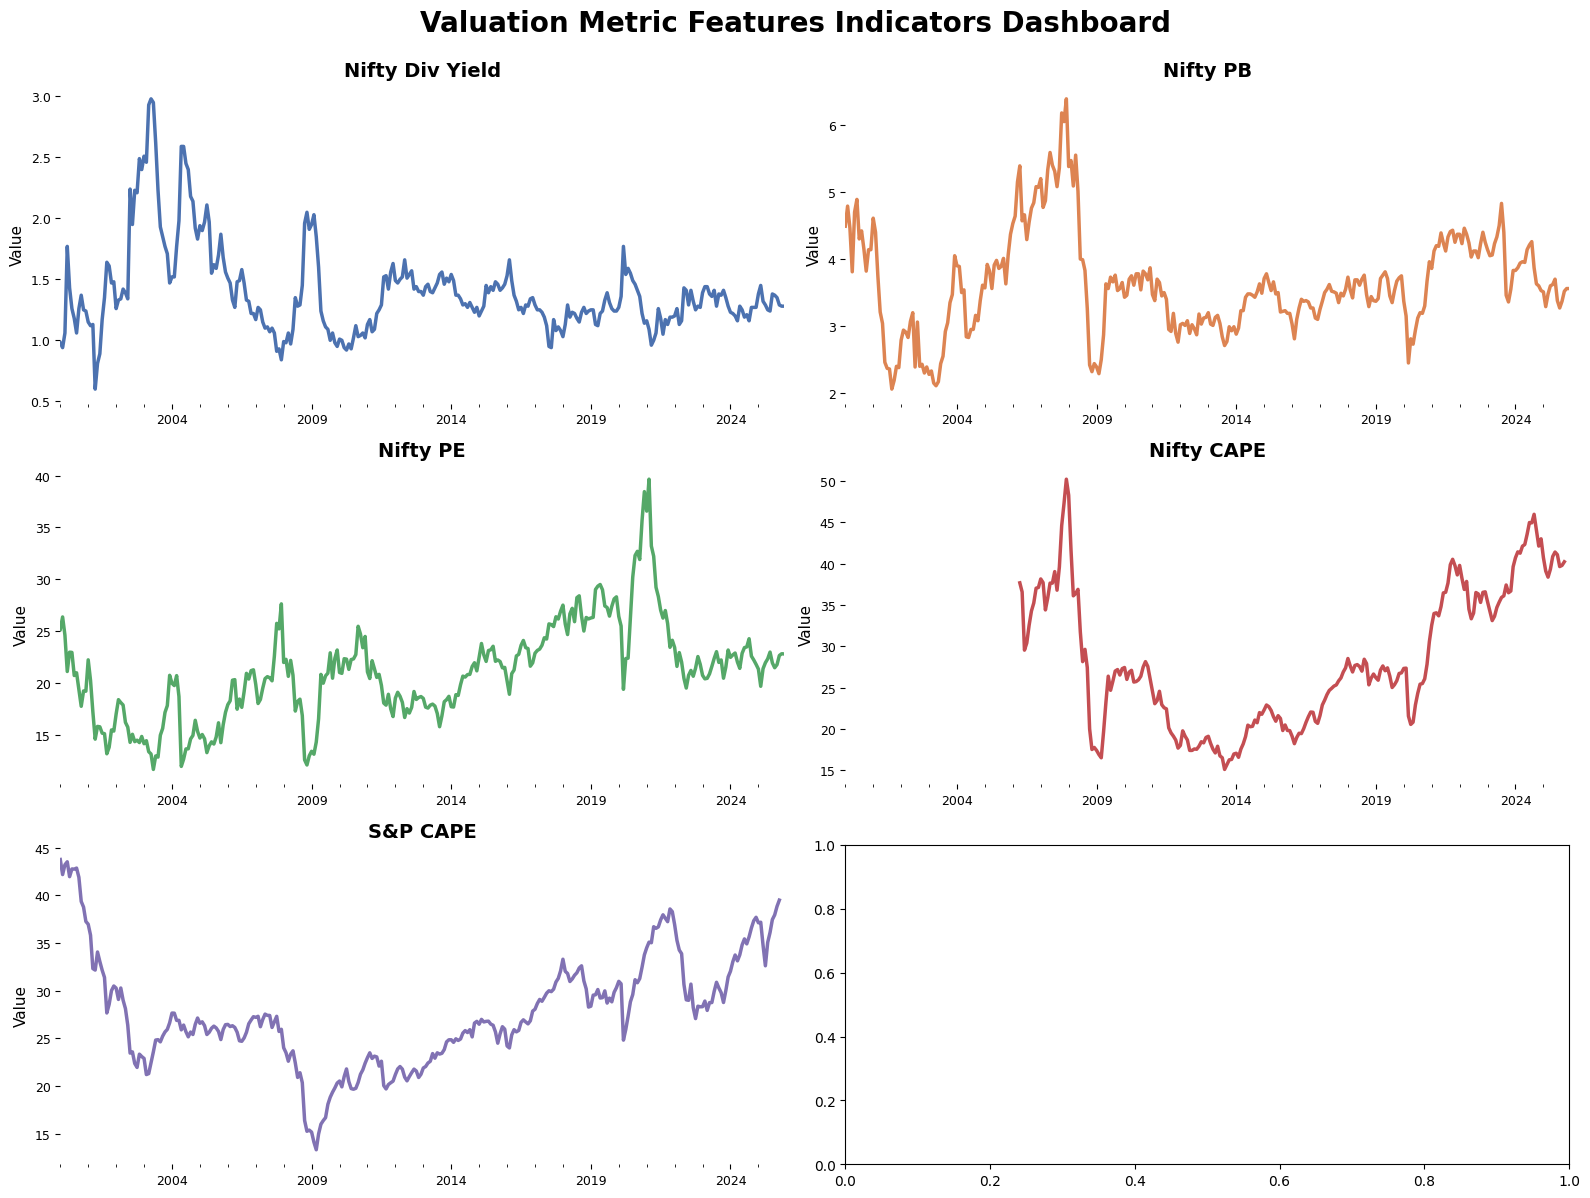

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12), dpi=100)
axes = axes.flatten()

for idx, col in enumerate(valuation_metrics.columns):
    ax = axes[idx]
    valuation_metrics[col].plot(ax=ax, linewidth=2.5, color=sns.color_palette("deep")[idx])
    ax.set_title(col, fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Value', fontsize=11)
    ax.tick_params(axis='both', labelsize=9)
    #ax.grid()

    # Remove top and right spines
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.suptitle('Valuation Metric Features Indicators Dashboard',
             fontsize=20, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [22]:
# Create and display compact summary
compact_summary_valuation = create_compact_summary(valuation_metrics)

# Display with better formatting
print("\n" + "=" * 120)
print("COMPACT SUMMARY STATISTICS")
print("=" * 120)
print(compact_summary_valuation.to_string(index=False))


COMPACT SUMMARY STATISTICS
         Column    Mean  Median Skewness Kurtosis   N     Min     Max
Nifty Div Yield  1.3948  1.3050   1.7570   3.9870 312  0.6000  2.9800
       Nifty PB  3.6230  3.5400   0.6558   0.9025 312  2.0600  6.3900
       Nifty PE 20.9683 20.9300   0.6329   1.2569 312 11.6500 39.6500
     Nifty CAPE 28.2549 26.7200   0.4229  -0.9331 235 15.1000 50.2400
       S&P CAPE 27.6687 26.7350   0.4435   0.2000 310 13.3200 43.7700


In [23]:
ind_vix = pd.read_csv("D:/Macro Research/Data/Processed Data/vix/ind_vix.csv", parse_dates=["date"])
ind_vix.set_index("date", inplace=True)
ind_vix = ind_vix['close']
ind_vix = ind_vix[~ind_vix.index.duplicated(keep='first')]

last_trade_dates = ind_vix.groupby(ind_vix.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_ind_vix = ind_vix.loc[last_trade_dates.values]
monthly_ind_vix = monthly_ind_vix.drop_duplicates()

us_vix = pd.read_csv(r"D:\Macro Research\Data\Processed Data\vix\us_vix.csv", parse_dates=["Date"])
us_vix.set_index("Date", inplace=True)
us_vix = us_vix[".VIX"]
us_vix = us_vix[~us_vix.index.duplicated(keep='first')]

last_trade_dates = us_vix.groupby(us_vix.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_us_vix = us_vix.loc[last_trade_dates.values]

monthly_ind_vix.index = monthly_ind_vix.index.to_period("M")
monthly_us_vix.index = monthly_us_vix.index.to_period("M")

vix_df = pd.DataFrame({
    "IND VIX" : monthly_ind_vix,
    "US VIX" : monthly_us_vix
})

vix_df["IND VIX chg"] = vix_df["IND VIX"].pct_change()
vix_df["US VIX chg"] = vix_df["US VIX"].pct_change()

vix_df

IND VIX  US VIX  IND VIX chg  US VIX chg
1995-12      NaN     NaN          NaN         NaN
1996-01      NaN   12.53          NaN         NaN
1996-02      NaN   17.04          NaN    0.359936
1996-03      NaN   18.88          NaN    0.107981
1996-04      NaN   15.83          NaN   -0.161547
...          ...     ...          ...         ...
2025-07    11.54   16.72    -0.282338   -0.000598
2025-08    11.75   15.36     0.018198   -0.081340
2025-09    11.07   16.28    -0.057872    0.059896
2025-10    12.19   17.44     0.101174    0.071253
2025-11    11.93   19.83    -0.021329    0.137041

[360 rows x 4 columns]

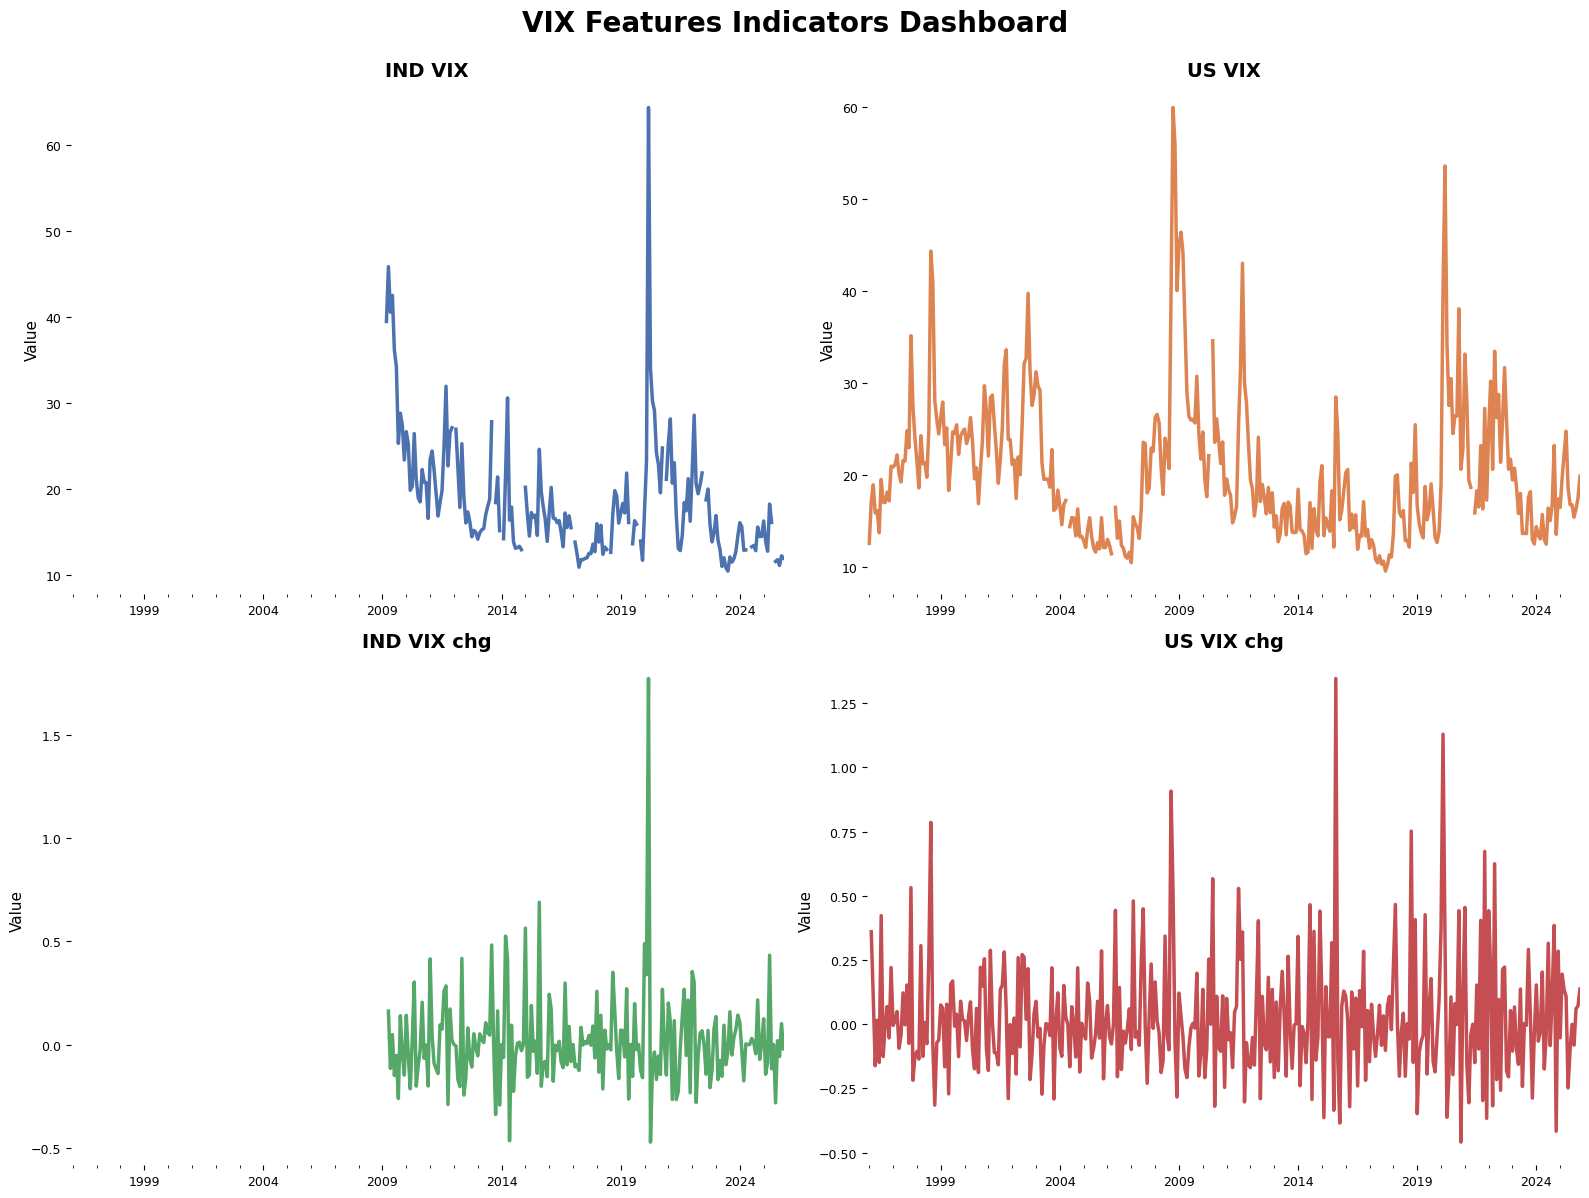

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=100)
axes = axes.flatten()

for idx, col in enumerate(vix_df.columns):
    ax = axes[idx]
    vix_df[col].plot(ax=ax, linewidth=2.5, color=sns.color_palette("deep")[idx])
    ax.set_title(col, fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Value', fontsize=11)
    ax.tick_params(axis='both', labelsize=9)
    #ax.grid()

    # Remove top and right spines
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.suptitle('VIX Features Indicators Dashboard',
             fontsize=20, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [25]:
# Create and display compact summary
compact_summary_vix = create_compact_summary(vix_df)

# Display with better formatting
print("\n" + "=" * 120)
print("COMPACT SUMMARY STATISTICS")
print("=" * 120)
print(compact_summary_vix.to_string(index=False))


COMPACT SUMMARY STATISTICS
     Column    Mean  Median Skewness Kurtosis   N     Min     Max
    IND VIX 18.6159 16.8350   2.4775   9.9567 188 10.4100 64.4100
     US VIX 20.2678 18.5700   1.6739   4.2953 355  9.5100 59.8900
IND VIX chg  0.0136 -0.0025   2.8815  19.2711 200 -0.4723  1.7715
 US VIX chg  0.0240 -0.0040   1.4678   4.7304 358 -0.4590  1.3457


In [26]:
sp500 = pd.read_csv("D:\Macro Research\Data\Processed Data\Equity Benchmark\SP500.csv", parse_dates=["Date"])
sp500.set_index("Date", inplace=True)
sp500 = sp500[".SPX"]

last_trade_dates = sp500.groupby(sp500.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_sp500 = sp500.loc[last_trade_dates.values]

monthly_sp500.index = monthly_sp500.index.to_period("M")

sp500_df = pd.DataFrame({"SP500" : monthly_sp500})
sp500_df = sp500_df[~sp500_df.index.duplicated(keep='first')]

sp500_df = np.log(sp500_df / sp500_df.shift(1))

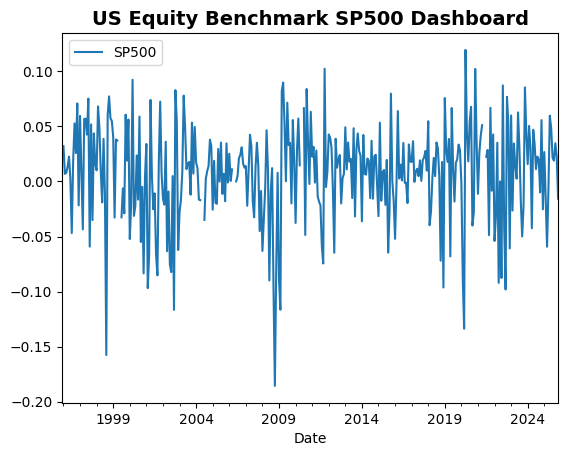

In [27]:
sp500_df.plot()
plt.title("US Equity Benchmark SP500 Dashboard", fontsize=14, fontweight='bold')
plt.show()

In [28]:
# Create and display compact summary
compact_summary_sp500 = create_compact_summary(sp500_df)

# Display with better formatting
print("\n" + "=" * 120)
print("COMPACT SUMMARY STATISTICS")
print("=" * 120)
print(compact_summary_sp500.to_string(index=False))


COMPACT SUMMARY STATISTICS
Column   Mean Median Skewness Kurtosis   N     Min    Max
 SP500 0.0071 0.0125  -0.7643   1.2970 349 -0.1856 0.1194


In [29]:
# Combine everything column-wise
macro_full = pd.concat([
    macro,
    fixed_income,
    commodity,
    valuation_metrics,
    vix_df,
    sp500_df
], axis=1)

macro_full = macro_full.sort_index()

macro_full = macro_full[macro_full.index >= "2005-01"]
macro_full

CPI   WPI          FDI  REPO  FDI change  REPO change  \
2005-01  4.365079   NaN  152000000.0  4.75   -0.518987     0.000000   
2005-02  4.166667   NaN  238000000.0  4.75    0.565789     0.000000   
2005-03  4.166667   NaN  275000000.0  4.75    0.155462     0.000000   
2005-04  4.960317   NaN  268000000.0  6.00   -0.025455     0.263158   
2005-05  3.740157   NaN  654000000.0  6.00    1.440299     0.000000   
...           ...   ...          ...   ...         ...          ...   
2025-08  3.155680  0.52 -616000000.0  5.50   -1.122246     0.000000   
2025-09  2.791347  0.13          NaN  5.50    0.000000     0.000000   
2025-10       NaN -1.21          NaN  5.50    0.000000     0.000000   
2025-11       NaN   NaN          NaN   NaN         NaN          NaN   
2025-12       NaN   NaN          NaN   NaN         NaN          NaN   

         Ind_spread  Us_spread  Us_spread Chg  Ind_spread Chg  ...  \
2005-01         NaN       1.13      -0.175182             NaN  ...   
2005-02         NaN       0.86      -0.238938             NaN  ...   
2005-03         NaN       0.79      -0.081395             NaN  ...   
2005-04         NaN       0.71      -0.101266             NaN  ...   
2005-05         NaN       0.57      -0.197183             NaN  ...   
...             ...        ...            ...             ...  ...   
2025-08       0.755       0.54       0.125000        0.143939  ...   
2025-09       0.849       0.64       0.185185        0.124503  ...   
2025-10       0.795       0.57      -0.109375       -0.063604  ...   
2025-11       0.723       0.53      -0.070175       -0.090566  ...   
2025-12         NaN        NaN            NaN             NaN  ...   

         Nifty Div Yield  Nifty PB  Nifty PE  Nifty CAPE  S&P CAPE  IND VIX  \
2005-01             1.94      3.57     14.68         NaN     26.59      NaN   
2005-02             1.90      3.92     15.02         NaN     26.74      NaN   
2005-03             1.97      3.82     14.60         NaN     26.34      NaN   
2005-04             2.11      3.56     13.27         NaN     25.41      NaN   
2005-05             1.97      3.91     13.94         NaN     25.65      NaN   
...                  ...       ...       ...         ...       ...      ...   
2025-08             1.37      3.27     21.46       39.66     37.96    11.75   
2025-09             1.35      3.37     21.76       39.80     38.85    11.07   
2025-10             1.29      3.52     22.64       40.24     39.51    12.19   
2025-11             1.28      3.56     22.81         NaN       NaN    11.93   
2025-12             1.28      3.56     22.79         NaN       NaN      NaN   

         US VIX  IND VIX chg  US VIX chg     SP500  
2005-01   12.82          NaN   -0.035365 -0.025616  
2005-02   12.08          NaN   -0.057722  0.018727  
2005-03   14.02          NaN    0.160596 -0.019303  
2005-04   15.31          NaN    0.092011 -0.020314  
2005-05   13.29          NaN   -0.131940  0.029512  
...         ...          ...         ...       ...  
2025-08   15.36     0.018198   -0.081340  0.018887  
2025-09   16.28    -0.057872    0.059896  0.034714  
2025-10   17.44     0.101174    0.071253  0.022433  
2025-11   19.83    -0.021329    0.137041 -0.015631  
2025-12     NaN          NaN         NaN       NaN  

[252 rows x 23 columns]

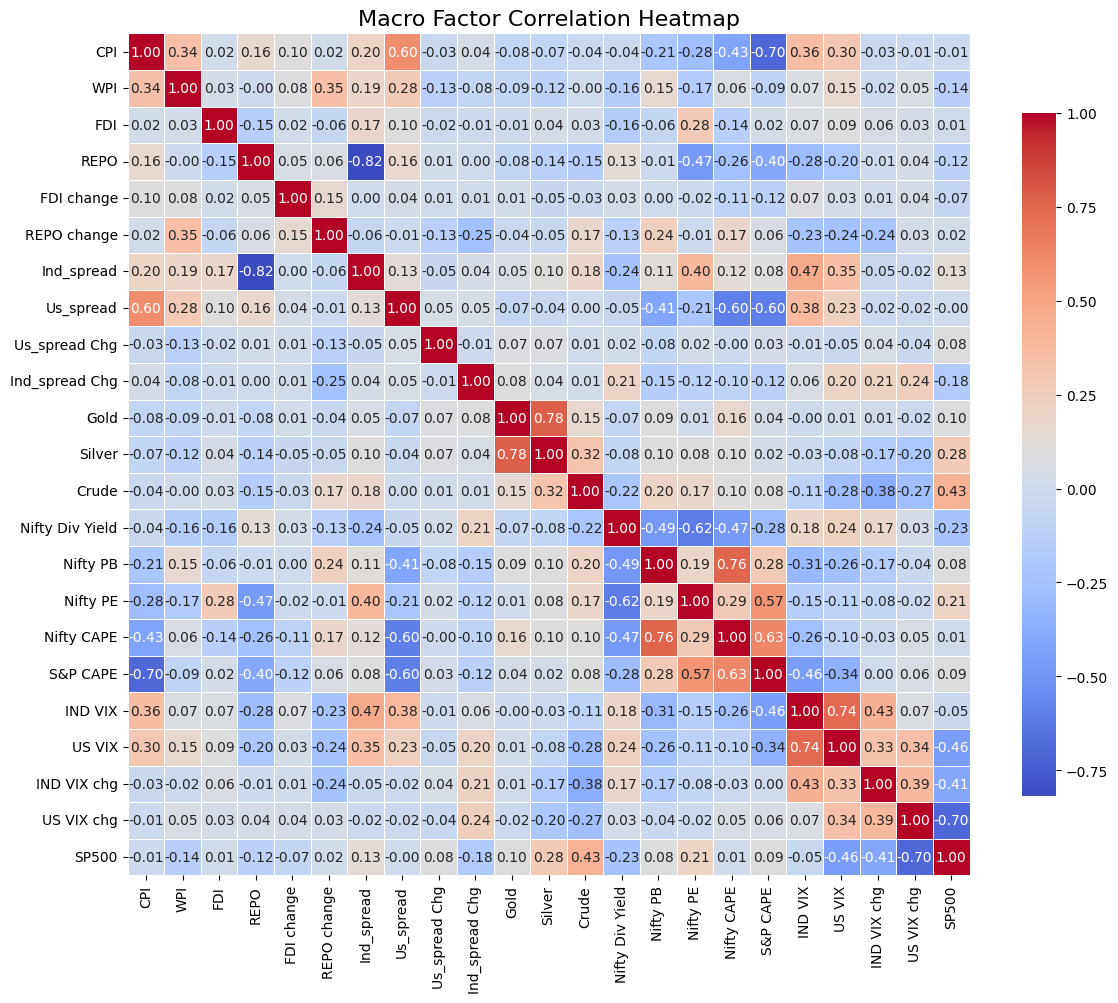

In [30]:
plt.figure(figsize=(12, 10))
sns.heatmap(macro_full.corr(), annot=True, fmt=".2f",
            cmap="coolwarm", linewidths=.5, square=True,
            cbar_kws={"shrink": .8})
plt.title("Macro Factor Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

In [31]:
def create_lagged_y_dataframe(metrics_df, windows=[3, 6, 12]):
    """
    Create Y(t+1) dataframe by shifting all features forward by one period
    This aligns Y(t+1) with X(t) for predictive analysis
    """
    # Identify all Y variable columns (excluding MonthlyPrice)
    y_cols = [c for c in metrics_df.columns if not c.startswith('MonthlyPrice_')]

    # Create lagged Y dataframe (shift forward so index at t contains Y(t+1))
    lagged_y_df = metrics_df[y_cols].shift(-1)

    # Rename columns to indicate they are forward-looking
    lagged_y_df.columns = [f"{col}" for col in lagged_y_df.columns]

    return lagged_y_df

# Create lagged Y dataframe
lagged_y_metrics = create_lagged_y_dataframe(monthly_indices_metrics)
print("Lagged Y DataFrame Preview:")
print(lagged_y_metrics.head())
print(f"\nOriginal shape: {monthly_indices_metrics.shape}")
print(f"Lagged shape: {lagged_y_metrics.shape}")

Lagged Y DataFrame Preview:
            LogReturn_.NSEI  LogReturn_.NIFMDCP100  LogReturn_.NIFSMCP100  \
Date                                                                        
2005-07-29         0.030810               0.071906               0.138315   
2005-08-31         0.086997               0.038650               0.015271   
2005-09-30        -0.092759              -0.090302              -0.113485   
2005-10-31         0.112118               0.096873               0.109137   
2005-11-30         0.067180               0.050361               0.057393   

            Return3m_.NSEI  Return3m_.NIFMDCP100  Return3m_.NIFSMCP100  \
Date                                                                     
2005-07-29             NaN                   NaN                   NaN   
2005-08-31             NaN                   NaN                   NaN   
2005-09-30        0.025364              0.020461              0.040916   
2005-10-31        0.112218              0.046259              

In [32]:
lagged_y_metrics.index = lagged_y_metrics.index.to_period("M")
lagged_y_metrics

LogReturn_.NSEI  LogReturn_.NIFMDCP100  LogReturn_.NIFSMCP100  \
Date                                                                     
2005-07         0.030810               0.071906               0.138315   
2005-08         0.086997               0.038650               0.015271   
2005-09        -0.092759              -0.090302              -0.113485   
2005-10         0.112118               0.096873               0.109137   
2005-11         0.067180               0.050361               0.057393   
...                  ...                    ...                    ...   
2025-07        -0.013884              -0.029582              -0.042050   
2025-08         0.007515               0.014287               0.019302   
2025-09         0.044153               0.056680               0.045526   
2025-10         0.007280               0.015151              -0.007005   
2025-11              NaN                    NaN                    NaN   

         Return3m_.NSEI  Return3m_.NIFMDCP100  Return3m_.NIFSMCP100  \
Date                                                                  
2005-07             NaN                   NaN                   NaN   
2005-08             NaN                   NaN                   NaN   
2005-09        0.025364              0.020461              0.040916   
2005-10        0.112218              0.046259              0.010983   
2005-11        0.090394              0.058583              0.054477   
...                 ...                   ...                   ...   
2025-07       -0.013084             -0.029478             -0.036699   
2025-08       -0.035504             -0.053764             -0.079284   
2025-09        0.038507              0.042253              0.023040   
2025-10        0.060720              0.089934              0.059529   
2025-11             NaN                   NaN                   NaN   

         Return6m_.NSEI  Return6m_.NIFMDCP100  Return6m_.NIFSMCP100  \
Date                                                                  
2005-07             NaN                   NaN                   NaN   
2005-08             NaN                   NaN                   NaN   
2005-09             NaN                   NaN                   NaN   
2005-10             NaN                   NaN                   NaN   
2005-11             NaN                   NaN                   NaN   
...                 ...                   ...                   ...   
2025-07        0.104053              0.163042              0.171889   
2025-08        0.046419              0.093997              0.091145   
2025-09        0.057035              0.105330              0.117452   
2025-10        0.046841              0.057806              0.020645   
2025-11             NaN                   NaN                   NaN   

         Return12m_.NSEI  ...  Drawdown12m_.NIFSMCP100  SemiStd3m_.NSEI  \
Date                      ...                                             
2005-07              NaN  ...                      NaN              NaN   
2005-08              NaN  ...                      NaN              NaN   
2005-09              NaN  ...                      NaN         0.053554   
2005-10              NaN  ...                      NaN         0.053554   
2005-11              NaN  ...                      NaN         0.053554   
...                  ...  ...                      ...              ...   
2025-07        -0.032059  ...                -0.101808         0.018970   
2025-08        -0.046482  ...                -0.079284         0.018970   
2025-09         0.062662  ...                -0.036398         0.008016   
2025-10         0.073720  ...                -0.043124         0.000000   
2025-11              NaN  ...                      NaN              NaN   

         SemiStd3m_.NIFMDCP100  SemiStd3m_.NIFSMCP100  SemiStd6m_.NSEI  \
Date                                                                     
2005-07                    NaN                    NaN              NaN   


In [33]:
final_dataset = lagged_y_metrics.join(macro_full, how="left")
final_dataset = final_dataset.sort_index()
final_dataset

LogReturn_.NSEI  LogReturn_.NIFMDCP100  LogReturn_.NIFSMCP100  \
Date                                                                     
2005-07         0.030810               0.071906               0.138315   
2005-08         0.086997               0.038650               0.015271   
2005-09        -0.092759              -0.090302              -0.113485   
2005-10         0.112118               0.096873               0.109137   
2005-11         0.067180               0.050361               0.057393   
...                  ...                    ...                    ...   
2025-07        -0.013884              -0.029582              -0.042050   
2025-08         0.007515               0.014287               0.019302   
2025-09         0.044153               0.056680               0.045526   
2025-10         0.007280               0.015151              -0.007005   
2025-11              NaN                    NaN                    NaN   

         Return3m_.NSEI  Return3m_.NIFMDCP100  Return3m_.NIFSMCP100  \
Date                                                                  
2005-07             NaN                   NaN                   NaN   
2005-08             NaN                   NaN                   NaN   
2005-09        0.025364              0.020461              0.040916   
2005-10        0.112218              0.046259              0.010983   
2005-11        0.090394              0.058583              0.054477   
...                 ...                   ...                   ...   
2025-07       -0.013084             -0.029478             -0.036699   
2025-08       -0.035504             -0.053764             -0.079284   
2025-09        0.038507              0.042253              0.023040   
2025-10        0.060720              0.089934              0.059529   
2025-11             NaN                   NaN                   NaN   

         Return6m_.NSEI  Return6m_.NIFMDCP100  Return6m_.NIFSMCP100  \
Date                                                                  
2005-07             NaN                   NaN                   NaN   
2005-08             NaN                   NaN                   NaN   
2005-09             NaN                   NaN                   NaN   
2005-10             NaN                   NaN                   NaN   
2005-11             NaN                   NaN                   NaN   
...                 ...                   ...                   ...   
2025-07        0.104053              0.163042              0.171889   
2025-08        0.046419              0.093997              0.091145   
2025-09        0.057035              0.105330              0.117452   
2025-10        0.046841              0.057806              0.020645   
2025-11             NaN                   NaN                   NaN   

         Return12m_.NSEI  ...  Nifty Div Yield  Nifty PB  Nifty PE  \
Date                      ...                                        
2005-07              NaN  ...             1.62      3.86     14.10   
2005-08              NaN  ...             1.59      3.89     14.78   
2005-09              NaN  ...             1.70      4.01     16.15   
2005-10              NaN  ...             1.87      3.63     14.23   
2005-11              NaN  ...             1.68      4.06     15.95   
...                  ...  ...              ...       ...       ...   
2025-07        -0.032059  ...             1.38      3.38     21.93   
2025-08        -0.046482  ...             1.37      3.27     21.46   
2025-09         0.062662  ...             1.35      3.37     21.76   
2025-10         0.073720  ...             1.29      3.52     22.64   
2025-11              NaN  ...             1.28      3.56     22.81   

         Nifty CAPE  S&P CAPE  IND VIX  US VIX  IND VIX chg  US VIX chg  \
Date                                                                      
2005-07         NaN     26.29      NaN   11.57          NaN   -0.039037   
2005-08         NaN     26.10      NaN   12.60          NaN   

In [34]:
final_dataset.columns

Index(['LogReturn_.NSEI', 'LogReturn_.NIFMDCP100', 'LogReturn_.NIFSMCP100',
       'Return3m_.NSEI', 'Return3m_.NIFMDCP100', 'Return3m_.NIFSMCP100',
       'Return6m_.NSEI', 'Return6m_.NIFMDCP100', 'Return6m_.NIFSMCP100',
       'Return12m_.NSEI', 'Return12m_.NIFMDCP100', 'Return12m_.NIFSMCP100',
       'Drawdown3m_.NSEI', 'Drawdown3m_.NIFMDCP100', 'Drawdown3m_.NIFSMCP100',
       'Drawdown6m_.NSEI', 'Drawdown6m_.NIFMDCP100', 'Drawdown6m_.NIFSMCP100',
       'Drawdown12m_.NSEI', 'Drawdown12m_.NIFMDCP100',
       'Drawdown12m_.NIFSMCP100', 'SemiStd3m_.NSEI', 'SemiStd3m_.NIFMDCP100',
       'SemiStd3m_.NIFSMCP100', 'SemiStd6m_.NSEI', 'SemiStd6m_.NIFMDCP100',
       'SemiStd6m_.NIFSMCP100', 'SemiStd12m_.NSEI', 'SemiStd12m_.NIFMDCP100',
       'SemiStd12m_.NIFSMCP100', 'CPI', 'WPI', 'FDI', 'REPO', 'FDI change',
       'REPO change', 'Ind_spread', 'Us_spread', 'Us_spread Chg',
       'Ind_spread Chg', 'Gold', 'Silver', 'Crude', 'Nifty Div Yield',
       'Nifty PB', 'Nifty PE', 'Nifty CAPE',

In [35]:
# import plotly.graph_objects as go

# def plot_3d_interactive(df, y_col, x_raw_col, x_chg_col,
#                         title_suffix="", sample_range=None):

#     if sample_range:
#         df = df.loc[sample_range[0]:sample_range[1]]

#     fig = go.Figure(
#         data=[
#             go.Scatter3d(
#                 x=df[x_raw_col],
#                 y=df[x_chg_col],
#                 z=df[y_col],
#                 mode='markers',
#                 marker=dict(size=4, opacity=0.7)
#             )
#         ]
#     )

#     fig.update_layout(
#         scene=dict(
#             xaxis_title=x_raw_col,
#             yaxis_title=x_chg_col,
#             zaxis_title=y_col
#         ),
#         title=f"3D Relationship: {y_col} vs {x_raw_col} & {x_chg_col} {title_suffix}",
#         height=700,
#         width=900
#     )

#     fig.show()


In [36]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def plot_3d(df, y_col, x_raw_col, x_chg_col,
            title_suffix="", sample_range=None):
    """
    df: dataframe
    y_col: dependent variable column
    x_raw_col: raw macro series
    x_chg_col: macro change series (difference / pct change)
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    if sample_range:
        df = df.loc[sample_range[0]:sample_range[1]]

    ax.scatter(
        df[x_raw_col],
        df[x_chg_col],
        df[y_col],
        alpha=0.7,
        s=40
    )

    ax.set_xlabel(x_raw_col, labelpad=10)
    ax.set_ylabel(x_chg_col, labelpad=10)
    ax.set_zlabel(y_col, labelpad=10)

    plt.title(f"3D Relationship: {y_col} vs {x_raw_col} & {x_chg_col} {title_suffix}")
    plt.show()


In [37]:
# y_vars = [c for c in final_dataset.columns if
#           any(x in c for x in ["Return", "Drawdown", "SemiStd"])]
#
# for y in y_vars:
#     plot_3d(
#         df=final_dataset,
#         y_col=y,
#         x_raw_col="REPO",
#         x_chg_col="REPO change",
#         title_suffix=f"({y})"
#     )


In [38]:
# y_vars = [c for c in final_dataset.columns if
#           any(x in c for x in ["Return", "Drawdown", "SemiStd"])]
#
# for y in y_vars:
#     plot_3d(
#         df=final_dataset,
#         y_col=y,
#         x_raw_col="Ind_spread",
#         x_chg_col="Ind_spread Chg",
#         title_suffix=f"({y})"
#     )


In [39]:
import plotly.graph_objects as go

def plot_3d_dropdown(df, y_vars, x_raw_col, x_chg_col, title_prefix="3D Relationship"):

    # Create traces
    traces = []
    for y in y_vars:
        traces.append(
            go.Scatter3d(
                x=df[x_raw_col],
                y=df[x_chg_col],
                z=df[y],
                mode="markers",
                marker=dict(size=4, opacity=0.7),
                name=y,
                visible=False
            )
        )

    traces[0].visible = True

    dropdown_buttons = []
    for i, y in enumerate(y_vars):

        visible_list = [False] * len(y_vars)
        visible_list[i] = True

        dropdown_buttons.append(
            dict(
                label=y,
                method="update",
                args=[
                    # 1️⃣ toggle visibility
                    {"visible": visible_list},

                    # 2️⃣ update title and axis labels
                    {
                        "title": f"{title_prefix}: {y} vs {x_raw_col} & {x_chg_col}",
                        "scene": {
                            "xaxis": {"title": x_raw_col},
                            "yaxis": {"title": x_chg_col},
                            "zaxis": {"title": y},     # THIS FIXES IT
                        }
                    }
                ]
            )
        )

    fig = go.Figure(data=traces)

    fig.update_layout(
        title=f"{title_prefix}: {y_vars[0]} vs {x_raw_col} & {x_chg_col}",
        scene=dict(
            xaxis_title=x_raw_col,
            yaxis_title=x_chg_col,
            zaxis_title=y_vars[0]
        ),
        height=800,
        width=1000,
        updatemenus=[
            dict(
                buttons=dropdown_buttons,
                direction="down",
                showactive=True,
                x=1.15,
                xanchor="left",
                y=1,
                yanchor="top"
            )
        ]
    )

    fig.show()


In [40]:
y_vars = [
    c for c in final_dataset.columns
    if any(x in c for x in ["Return", "Drawdown", "SemiStd"])
]

plot_3d_dropdown(
    df=final_dataset,
    y_vars=y_vars,
    x_raw_col="REPO",
    x_chg_col="REPO change",
    title_prefix="NIFTY Volatility Regime"
)


In [41]:
import numpy as np
import plotly.graph_objects as go
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def plot_3d_surface_dropdown(df, y_vars, x_col, y_col, degree=2, title_prefix="3D Regression Surface"):

    # Build traces (scatter + surface per variable)
    traces = []

    for z_col in y_vars:

        # ------------------- CLEAN DATA -------------------
        clean_df = df[[x_col, y_col, z_col]].dropna()

        X = clean_df[[x_col, y_col]].values
        Z = clean_df[z_col].values

        # ------------------- POLYNOMIAL REGRESSION -------------------
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)

        model = LinearRegression()
        model.fit(X_poly, Z)

        # ------------------- 3D MESHGRID -------------------
        x_range = np.linspace(clean_df[x_col].min(), clean_df[x_col].max(), 40)
        y_range = np.linspace(clean_df[y_col].min(), clean_df[y_col].max(), 40)
        xx, yy = np.meshgrid(x_range, y_range)

        grid_points = np.c_[xx.ravel(), yy.ravel()]
        Z_pred = model.predict(poly.transform(grid_points)).reshape(xx.shape)

        # ------------------- SCATTER + SURFACE TRACE -------------------
        traces.append(

            # One combined trace list per variable
            [
                go.Scatter3d(
                    x=clean_df[x_col],
                    y=clean_df[y_col],
                    z=clean_df[z_col],
                    mode='markers',
                    marker=dict(size=3, opacity=0.7),
                    name=f"Data ({z_col})",
                    visible=False
                ),

                go.Surface(
                    x=x_range,
                    y=y_range,
                    z=Z_pred,
                    colorscale='Viridis',
                    opacity=0.75,
                    name=f"Surface ({z_col})",
                    visible=False
                )
            ]
        )

    # Flatten traces list
    flat_traces = [t for group in traces for t in group]

    # Make the first variable visible by default
    flat_traces[0].visible = True
    flat_traces[1].visible = True   # surface

    # ------------------- DROPDOWN BUTTONS -------------------
    buttons = []
    for i, z_col in enumerate(y_vars):

        # Visibility mask: 2 traces per variable
        visible_mask = [False] * len(flat_traces)
        visible_mask[2*i] = True       # scatter
        visible_mask[2*i + 1] = True   # surface

        buttons.append(
            dict(
                label=z_col,
                method="update",
                args=[
                    {"visible": visible_mask},
                    {
                        "title": f"{title_prefix}: {x_col} vs {y_col} → {z_col}",
                        "scene": {
                            "zaxis_title": z_col
                        }
                    }
                ]
            )
        )

    # ------------------- FINAL FIGURE -------------------
    fig = go.Figure(data=flat_traces)

    fig.update_layout(
        title=f"{title_prefix}: {x_col} vs {y_col} → {y_vars[0]}",
        height=800,
        width=1000,
        scene=dict(
            xaxis_title=x_col,
            yaxis_title=y_col,
            zaxis_title=y_vars[0]
        ),
        updatemenus=[
            dict(
                buttons=buttons,
                direction="down",
                x=1.15,
                xanchor="left",
                y=1,
                yanchor="top",
                showactive=True
            )
        ]
    )

    fig.show()


In [45]:
y_vars = [
    c for c in final_dataset.columns
    if any(x in c for x in ["Return", "Drawdown", "SemiStd"])
]

plot_3d_surface_dropdown(
    df=final_dataset,
    y_vars=y_vars,
    x_col="US VIX",
    y_col="US VIX chg",
    degree=2,
    title_prefix="NIFTY Volatility Regime (3D Surface)"
)


In [43]:
import numpy as np
import plotly.graph_objects as go
from scipy.interpolate import griddata

def plot_3d_dropdown_contour(df, y_vars, x_raw_col, x_chg_col, title_prefix="3D Contour"):

    # -------- Precompute all surfaces --------
    surfaces = []      # Z_pred grids
    scatters = []      # Actual points
    grids_x = grids_y = None

    for y_col in y_vars:
        clean_df = df[[x_raw_col, x_chg_col, y_col]].dropna()

        x = clean_df[x_raw_col].values
        y = clean_df[x_chg_col].values
        z = clean_df[y_col].values

        # Grid for interpolation
        grid_x, grid_y = np.meshgrid(
            np.linspace(x.min(), x.max(), 50),
            np.linspace(y.min(), y.max(), 50)
        )

        # Try cubic → fallback to linear
        try:
            grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')
        except:
            grid_z = griddata((x, y), z, (grid_x, grid_y), method='linear')

        surfaces.append(grid_z)
        scatters.append((x, y, z))

        if grids_x is None:
            grids_x, grids_y = grid_x, grid_y

    # -------- Build Figure --------
    fig = go.Figure()

    # Add ALL traces (visible toggled by dropdown)
    for i, y_col in enumerate(y_vars):

        # Surface
        fig.add_trace(go.Surface(
            x=grids_x,
            y=grids_y,
            z=surfaces[i],
            colorscale="Viridis",
            opacity=0.85,
            visible=(i == 0),   # only first visible
            name=f"{y_col} Surface"
        ))

        # Scatter points
        x, y, z = scatters[i]
        fig.add_trace(go.Scatter3d(
            x=x, y=y, z=z,
            mode="markers",
            marker=dict(size=3, opacity=0.65, color="black"),
            visible=(i == 0),
            name=f"{y_col} Data"
        ))

    # -------- Dropdown menu --------
    dropdown_buttons = []
    for i, y_col in enumerate(y_vars):
        visibility_array = [False] * (2 * len(y_vars))

        # 2 traces per variable → surface + scatter
        visibility_array[2*i] = True
        visibility_array[2*i + 1] = True

        dropdown_buttons.append(
            dict(
                label=y_col,
                method="update",
                args=[
                    {"visible": visibility_array},
                    {"title": f"{title_prefix}: {y_col}"}
                ]
            )
        )

    fig.update_layout(
        updatemenus=[
            dict(
                buttons=dropdown_buttons,
                direction="down",
                x=1.25,
                y=0.95
            )
        ],
        title=f"{title_prefix}: {y_vars[0]}",
        height=800,
        width=1100,
        scene=dict(
            xaxis_title=x_raw_col,
            yaxis_title=x_chg_col,
            zaxis_title=y_vars[0]
        )
    )

    fig.show()


In [44]:
y_vars = [
    c for c in final_dataset.columns
    if any(x in c for x in ["Return", "Drawdown", "SemiStd"])
]

plot_3d_dropdown_contour(
    df=final_dataset,
    y_vars=y_vars,
    x_raw_col="REPO",
    x_chg_col="REPO change",
    title_prefix="NIFTY Volatility Regime"
)
